# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [125]:
!pip install sqlalchemy

In [126]:
import pandas as pd
from sqlalchemy import create_engine

In [127]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [128]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [129]:
engine = create_engine(connection_string)

In [130]:
query = '''
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
'''

In [131]:
df = pd.read_sql_query(query, con=engine)

In [132]:
df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fffcd3dde79eb2c,mobile,368562,2024-10-27,2024-10-27 17:53:53,rub,1448.36,6,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290607,fffcd3dde79eb2c,mobile,368591,2024-10-27,2024-10-27 17:54:52,rub,965.57,4,0.0,33189,e3dcdb45-9eaa-4ce4-9b85-1562e548172e,другое,Весь в билетах,Глиногорск,Каменевский регион
290608,fffcd3dde79eb2c,desktop,8473772,2024-10-30,2024-10-30 13:37:43,rub,178.95,2,3.0,205231,74883818-57a6-494a-b162-bb0260877cbf,театр,Прачечная,Глиногорск,Каменевский регион
290609,fffeeb3c120cf0b,desktop,5526067,2024-09-24,2024-09-24 10:07:42,rub,661.53,2,NaN,454526,6f4c6a50-0106-407b-8f54-332c740b01da,стендап,Билеты без проблем,Ягодиновка,Широковская область


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

- В day_since_prev стоит привести данные к int 
- Категориальные данные (service_name,city_name,region_name) стоит привести к нижнему регистра для устранения неявных дубликатов

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [133]:
df_currency=pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [135]:
df_currency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [136]:
df_currency['data']=df_currency['data'].astype('datetime64')

In [137]:
df_currency['coeff_cur']=df_currency['curs']/df_currency['nominal']

In [138]:
df_currency

,data,nominal,curs,cdx,coeff_cur
0,2024-01-10,100,19.9391,kzt,0.199391
1,2024-01-11,100,19.7255,kzt,0.197255
2,2024-01-12,100,19.5839,kzt,0.195839
3,2024-01-13,100,19.4501,kzt,0.194501
4,2024-01-14,100,19.4501,kzt,0.194501
...,...,...,...,...,...
352,2024-12-27,100,19.2705,kzt,0.192705
353,2024-12-28,100,19.5105,kzt,0.195105
354,2024-12-29,100,19.4860,kzt,0.194860
355,2024-12-30,100,19.4860,kzt,0.194860


In [139]:
new_df=df.merge(df_currency,left_on='order_dt',right_on='data',how='inner')

In [140]:
def convert_currency(row):
    if row['currency_code']=='rub':
        return row['revenue']
    elif row['currency_code'] =='kzt':
        return row['revenue']*row['coeff_cur']
    else:
        return None 

In [141]:
new_df['revenue_rub']=new_df.apply(convert_currency,axis=1)

In [142]:
new_df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,...,event_type_main,service_name,city_name,region_name,data,nominal,curs,cdx,coeff_cur,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,...,театр,Край билетов,Глиногорск,Каменевский регион,2024-08-20,100,18.6972,kzt,0.186972,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.25,4,NaN,453660,...,концерты,Билеты без проблем,Каменский,Боровлянский край,2024-08-20,100,18.6972,kzt,0.186972,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.72,2,NaN,211375,...,другое,Лучшие билеты,Радужнополье,Широковская область,2024-08-20,100,18.6972,kzt,0.186972,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.76,3,5.0,552779,...,концерты,Мой билет,Луговаярово,Широковская область,2024-08-20,100,18.6972,kzt,0.186972,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.40,4,NaN,508859,...,концерты,Яблоко,Сосновечин,Травиницкий округ,2024-08-20,100,18.6972,kzt,0.186972,1550.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fe237d2cfd6e503,mobile,1160001,2024-06-10,2024-06-10 07:14:53,rub,1007.51,3,0.0,439889,...,концерты,Облачко,Леснойск,Чистогорская область,2024-06-10,100,19.8618,kzt,0.198618,1007.51
290607,fe237d2cfd6e503,mobile,5931777,2024-06-10,2024-06-10 15:18:11,rub,58.09,1,0.0,523552,...,концерты,Билеты без проблем,Глиногорск,Каменевский регион,2024-06-10,100,19.8618,kzt,0.198618,58.09
290608,fe237d2cfd6e503,mobile,3866020,2024-06-10,2024-06-10 14:35:58,rub,10.53,1,0.0,384441,...,другое,Лови билет!,Озёрск,Североярская область,2024-06-10,100,19.8618,kzt,0.198618,10.53
290609,fe237d2cfd6e503,mobile,3141136,2024-06-10,2024-06-10 18:52:06,rub,179.53,2,0.0,534554,...,другое,Мой билет,Светополье,Яблоневская область,2024-06-10,100,19.8618,kzt,0.198618,179.53


In [143]:
new_df=new_df.drop(['nominal','curs','cdx','data'],axis=1)

In [144]:
new_df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,coeff_cur,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,0.186972,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.25,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,Билеты без проблем,Каменский,Боровлянский край,0.186972,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.72,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,Лучшие билеты,Радужнополье,Широковская область,0.186972,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.76,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,Мой билет,Луговаярово,Широковская область,0.186972,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.40,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,Яблоко,Сосновечин,Травиницкий округ,0.186972,1550.40


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [145]:
import matplotlib.pyplot as plt 
import numpy as np

In [146]:
new_df['currency_code'].unique()

array(['rub', 'kzt'], dtype=object)

In [147]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [148]:
new_df[['revenue_rub','coeff_cur','revenue','days_since_prev']]=new_df[['revenue_rub','coeff_cur','revenue','days_since_prev']].apply(pd.to_numeric,downcast='float')

In [149]:
new_df[['event_id','tickets_count','order_id']]=new_df[['event_id','tickets_count','order_id']].apply(pd.to_numeric,downcast='integer')

In [150]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290611 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [151]:
new_df['device_type_canonical'].unique()

array(['mobile', 'desktop'], dtype=object)

In [152]:
new_df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,coeff_cur,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,0.186972,1521.939941
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.250000,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,Билеты без проблем,Каменский,Боровлянский край,0.186972,1503.250000
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.720001,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,Лучшие билеты,Радужнополье,Широковская область,0.186972,39.720001
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.759995,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,Мой билет,Луговаярово,Широковская область,0.186972,204.759995
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.400024,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,Яблоко,Сосновечин,Травиницкий округ,0.186972,1550.400024


In [153]:
new_df['event_type_main']=new_df['event_type_main'].str.lower()

In [154]:
new_df['service_name']=new_df['service_name'].str.lower()

In [155]:
new_df['city_name']=new_df['city_name'].str.lower()

In [156]:
new_df['region_name']=new_df['region_name'].str.lower()

In [157]:
new_df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,coeff_cur,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,глиногорск,каменевский регион,0.186972,1521.939941
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.250000,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,билеты без проблем,каменский,боровлянский край,0.186972,1503.250000
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.720001,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,лучшие билеты,радужнополье,широковская область,0.186972,39.720001
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.759995,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,мой билет,луговаярово,широковская область,0.186972,204.759995
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.400024,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,яблоко,сосновечин,травиницкий округ,0.186972,1550.400024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fe237d2cfd6e503,mobile,1160001,2024-06-10,2024-06-10 07:14:53,rub,1007.510010,3,0.0,439889,58574140-962c-49a3-af70-b773a05661a3,концерты,облачко,леснойск,чистогорская область,0.198618,1007.510010
290607,fe237d2cfd6e503,mobile,5931777,2024-06-10,2024-06-10 15:18:11,rub,58.090000,1,0.0,523552,b191f925-e0cb-43b0-a49e-8fb1563c05d0,концерты,билеты без проблем,глиногорск,каменевский регион,0.198618,58.090000
290608,fe237d2cfd6e503,mobile,3866020,2024-06-10,2024-06-10 14:35:58,rub,10.530000,1,0.0,384441,108c5bfa-b11e-47ac-a482-d0e76702508e,другое,лови билет!,озёрск,североярская область,0.198618,10.530000
290609,fe237d2cfd6e503,mobile,3141136,2024-06-10,2024-06-10 18:52:06,rub,179.529999,2,0.0,534554,3ccd92b9-5450-40a1-a7a8-5075cf90cc6a,другое,мой билет,светополье,яблоневская область,0.198618,179.529999


In [158]:
new_df['revenue_rub'].describe()

count    290611.000000
mean        555.571960
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

In [159]:
new_df['tickets_count'].describe()

count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

In [160]:
new_df['revenue_rub'].median()

351.14

In [161]:
new_df['tickets_count'].median()

3.0

In [162]:
new_df['revenue_rub'].mode()

0    0.0
dtype: float32

In [163]:
new_df['tickets_count'].mode()

0    3
dtype: int8

Text(0.5, 0, 'Выручка')

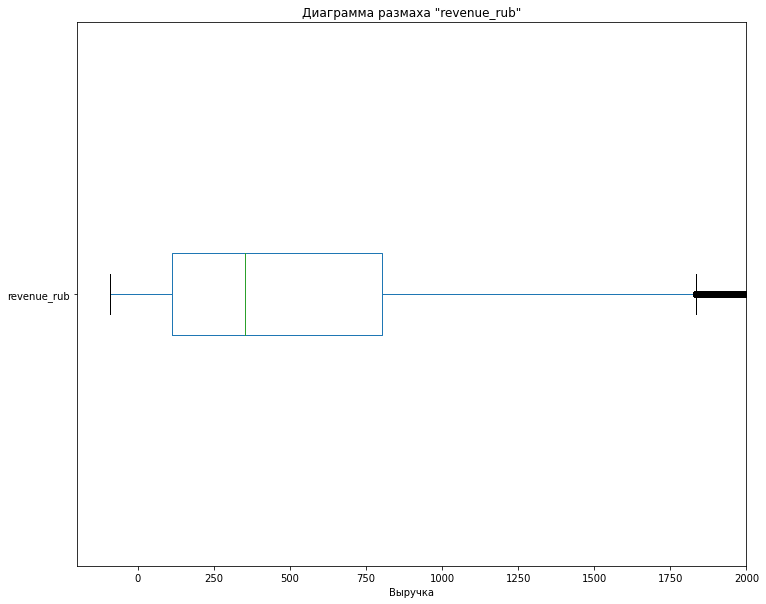

In [164]:
new_df['revenue_rub'].plot(kind='box',
                           figsize=(12,10),
                           vert=False,
                           title='Диаграмма размаха "revenue_rub"')
plt.xlim(left=-200,right=2000)
plt.xlabel('Выручка')

In [165]:
percentile_99=np.percentile(new_df['revenue_rub'],99)

In [166]:
fil_new_df=new_df[new_df['revenue_rub']<percentile_99]

In [167]:
fil_new_df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,coeff_cur,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,глиногорск,каменевский регион,0.186972,1521.939941
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.250000,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,билеты без проблем,каменский,боровлянский край,0.186972,1503.250000
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.720001,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,лучшие билеты,радужнополье,широковская область,0.186972,39.720001
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.759995,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,мой билет,луговаярово,широковская область,0.186972,204.759995
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.400024,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,яблоко,сосновечин,травиницкий округ,0.186972,1550.400024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fe237d2cfd6e503,mobile,1160001,2024-06-10,2024-06-10 07:14:53,rub,1007.510010,3,0.0,439889,58574140-962c-49a3-af70-b773a05661a3,концерты,облачко,леснойск,чистогорская область,0.198618,1007.510010
290607,fe237d2cfd6e503,mobile,5931777,2024-06-10,2024-06-10 15:18:11,rub,58.090000,1,0.0,523552,b191f925-e0cb-43b0-a49e-8fb1563c05d0,концерты,билеты без проблем,глиногорск,каменевский регион,0.198618,58.090000
290608,fe237d2cfd6e503,mobile,3866020,2024-06-10,2024-06-10 14:35:58,rub,10.530000,1,0.0,384441,108c5bfa-b11e-47ac-a482-d0e76702508e,другое,лови билет!,озёрск,североярская область,0.198618,10.530000
290609,fe237d2cfd6e503,mobile,3141136,2024-06-10,2024-06-10 18:52:06,rub,179.529999,2,0.0,534554,3ccd92b9-5450-40a1-a7a8-5075cf90cc6a,другое,мой билет,светополье,яблоневская область,0.198618,179.529999


Text(0, 0.5, 'Частота покупок')

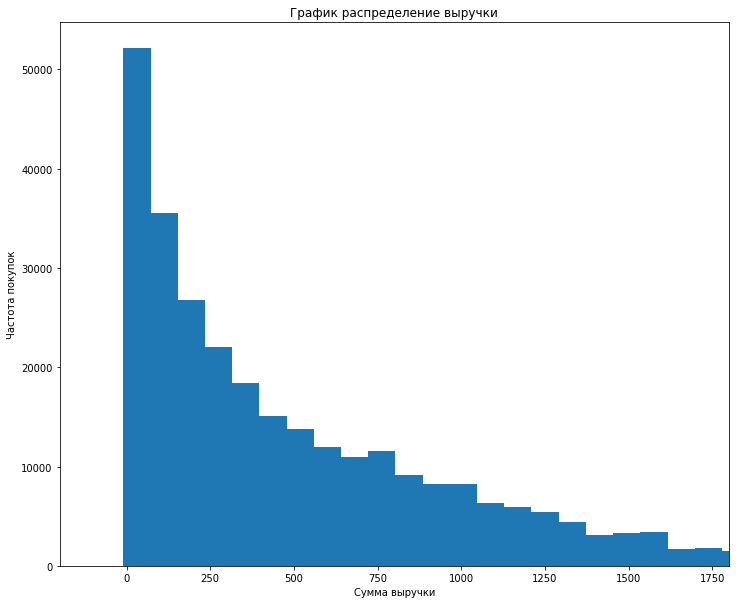

In [168]:
new_df['revenue_rub'].plot(kind='hist',
                           figsize=(12,10),
                           bins=1000,
                           title='График распределение выручки')
plt.xlim(left=-200,right=1800)
plt.xlabel('Сумма выручки')
plt.ylabel('Частота покупок')

Text(0.5, 0, 'Количество билетов')

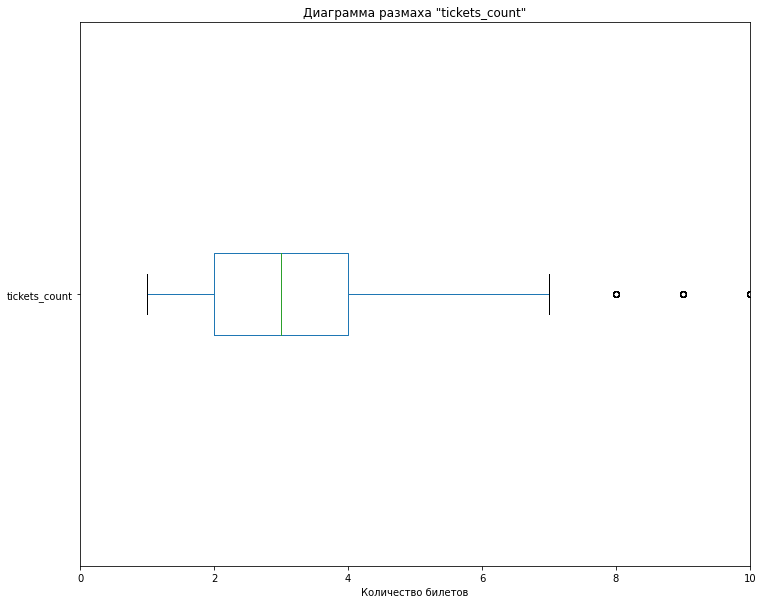

In [169]:
new_df['tickets_count'].plot(kind='box',
                           figsize=(12,10),
                           vert=False,
                           title='Диаграмма размаха "tickets_count"')
plt.xlim(left=0,right=10)
plt.xlabel('Количество билетов')

Text(0, 0.5, 'Частота покупок')

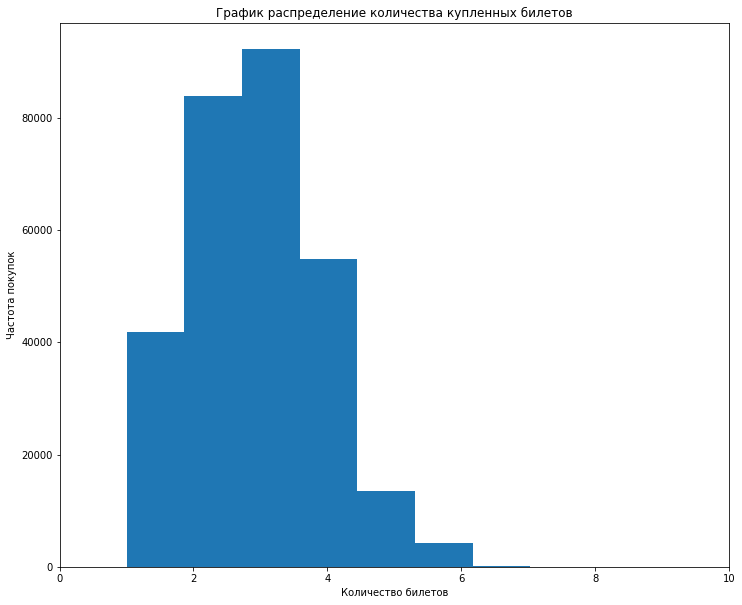

In [170]:
new_df['tickets_count'].plot(kind='hist',
                           figsize=(12,10),
                           bins=65,
                           title='График распределение количества купленных билетов')
plt.xlim(left=0,right=10)
plt.xlabel('Количество билетов')
plt.ylabel('Частота покупок')

Чтобы привести выручку к единой валюте в датасете df_currency поле «data» приведено к типу «datettime64»,
создано поле "coeff_cur” - коэффициент для пересчета валюты.

После объединения датасетов с помощью функции convert_currency выручка приведена к единой валюте - российскому рублю. Результаты преобразования в столбце revenue_rub. 

Лишние столбцы (nominal, curs, cdx,data) были убраны с помощью метода drop()

Столбцы (event_type_main, service_name, city_name,region_name)  приведены к нижнему регистру чтобы избежать неявных дубликатов 

Был проведен анализ столбцов «revenue_rub» и «tickets_count»:

- “revenue_rub”

Есть отрицательные значения

По гистограмме видно что это похоже на правоассиметричное распределение, где больше всего значений в районе 0-350, а выбросы влияют на увеличение среднего арифметического 

Чтобы исключить выбросы из расчета поле отфильтровано по 99 процентилю.

- “tickets_count”

Среднее - 3.0 , медиана - 2,75, здесь видно что выбросы не так сильно влияют на медиану, либо их немного 
 
Здесь тоже правосимметричное распределение

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [171]:
fil_new_df

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,coeff_cur,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,край билетов,глиногорск,каменевский регион,0.186972,1521.939941
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.250000,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,билеты без проблем,каменский,боровлянский край,0.186972,1503.250000
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.720001,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,лучшие билеты,радужнополье,широковская область,0.186972,39.720001
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.759995,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,мой билет,луговаярово,широковская область,0.186972,204.759995
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.400024,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,яблоко,сосновечин,травиницкий округ,0.186972,1550.400024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290606,fe237d2cfd6e503,mobile,1160001,2024-06-10,2024-06-10 07:14:53,rub,1007.510010,3,0.0,439889,58574140-962c-49a3-af70-b773a05661a3,концерты,облачко,леснойск,чистогорская область,0.198618,1007.510010
290607,fe237d2cfd6e503,mobile,5931777,2024-06-10,2024-06-10 15:18:11,rub,58.090000,1,0.0,523552,b191f925-e0cb-43b0-a49e-8fb1563c05d0,концерты,билеты без проблем,глиногорск,каменевский регион,0.198618,58.090000
290608,fe237d2cfd6e503,mobile,3866020,2024-06-10,2024-06-10 14:35:58,rub,10.530000,1,0.0,384441,108c5bfa-b11e-47ac-a482-d0e76702508e,другое,лови билет!,озёрск,североярская область,0.198618,10.530000
290609,fe237d2cfd6e503,mobile,3141136,2024-06-10,2024-06-10 18:52:06,rub,179.529999,2,0.0,534554,3ccd92b9-5450-40a1-a7a8-5075cf90cc6a,другое,мой билет,светополье,яблоневская область,0.198618,179.529999


In [172]:
userp_df=fil_new_df.sort_values('order_ts').groupby('user_id').agg({'order_ts': ['min','max'],
                                 'device_type_canonical':'first',
                                 'region_name':'first',
                                 'service_name':'first',
                                 'event_type_main': 'first',
                                 'order_id':'count',
                                 'revenue_rub':'mean',
                                 'tickets_count':'mean',
                                 'days_since_prev':'mean'})

In [173]:
userp_df.head()

order_ts                     device_type_canonical  \
                                min                 max                 first   
user_id                                                                         
0002849b70a3ce2 2024-08-20 16:08:03 2024-08-20 16:08:03                mobile   
0005ca5e93f2cf4 2024-07-23 18:36:24 2024-10-06 13:56:02                mobile   
000898990054619 2024-07-13 19:40:48 2024-10-23 15:12:00                mobile   
00096d1f542ab2b 2024-08-15 16:48:48 2024-08-15 16:48:48               desktop   
000a55a418c128c 2024-09-29 19:39:12 2024-10-15 10:29:04                mobile   

                          region_name   service_name event_type_main order_id  \
                                first          first           first    count   
user_id                                                                         
0002849b70a3ce2    каменевский регион   край билетов           театр        1   
0005ca5e93f2cf4    каменевский регион      мой билет        выставки        2   
000898990054619  североярская область    лови билет!          другое        3   
00096d1f542ab2b    каменевский регион   край билетов           театр        1   
000a55a418c128c      поленовский край  лучшие билеты           театр        2   

                 revenue_rub tickets_count days_since_prev  
                        mean          mean            mean  
user_id                                                     
0002849b70a3ce2  1521.939941      4.000000             NaN  
0005ca5e93f2cf4   774.010010      3.000000            75.0  
000898990054619   767.213318      2.666667            51.0  
00096d1f542ab2b   917.830017      4.000000             NaN  
000a55a418c128c    61.309998      1.500000            16.0

In [174]:
userp_df.describe()

,order_id,revenue_rub,tickets_count,days_since_prev
,count,mean,mean,mean
count,21848.000000,21848.000000,21848.000000,13510.000000
mean,13.163859,543.385071,2.742918,15.863060
std,121.624128,429.734863,0.913389,22.321573
min,1.000000,-10.770000,1.000000,0.000000
25%,1.000000,212.754997,2.000000,1.000000
50%,2.000000,466.845078,2.750000,8.000000
75%,5.000000,763.370605,3.076923,20.428572
max,10175.000000,2624.814697,11.000000,148.000000


In [175]:
userp_df.columns=['first_order','last_order','device_type','region','service_name_first','event_type_first',
                  'order_count','revenue_rub_mean','tickets_count_mean','days_since_prev_mean']

In [176]:
userp_df.head()

,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean
user_id,,,,,,,,,,
0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN
0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0
000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0
00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN
000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0


In [177]:
def is_twof(row):
    if row['order_count']>=2:
        return 1
    else:
        return 0

In [178]:
userp_df['is_two']=userp_df.apply(is_twof,axis=1)

In [179]:
def is_fivef(row):
    if row['order_count']>=5:
        return 1
    else:
        return 0

In [180]:
userp_df['is_five']=userp_df.apply(is_fivef,axis=1)

In [181]:
userp_df.head()

,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
user_id,,,,,,,,,,,,
0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [182]:
userpr_df=userp_df.reset_index()

In [183]:
userpr_df.head()

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [184]:
userpr_df['user_id'].count()

21848

In [185]:
userpr_df['revenue_rub_mean'].mean()

543.3851

In [186]:
two_orders=userpr_df[userpr_df['order_count']>=2]

In [187]:
two_orders['user_id'].count()/userpr_df['user_id'].count()

0.6171274258513365

In [188]:
five_orders=userpr_df[userpr_df['order_count']>=5]

In [189]:
five_orders['user_id'].count()/userpr_df['user_id'].count()

0.29004943244232884

In [190]:
userpr_df['order_count'].describe()

count    21848.000000
mean        13.163859
std        121.624128
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10175.000000
Name: order_count, dtype: float64

In [191]:
userpr_df['order_count'].median()

2.0

In [192]:
userpr_df['tickets_count_mean'].median()

2.75

Text(0.5, 0, 'Количество заказов')

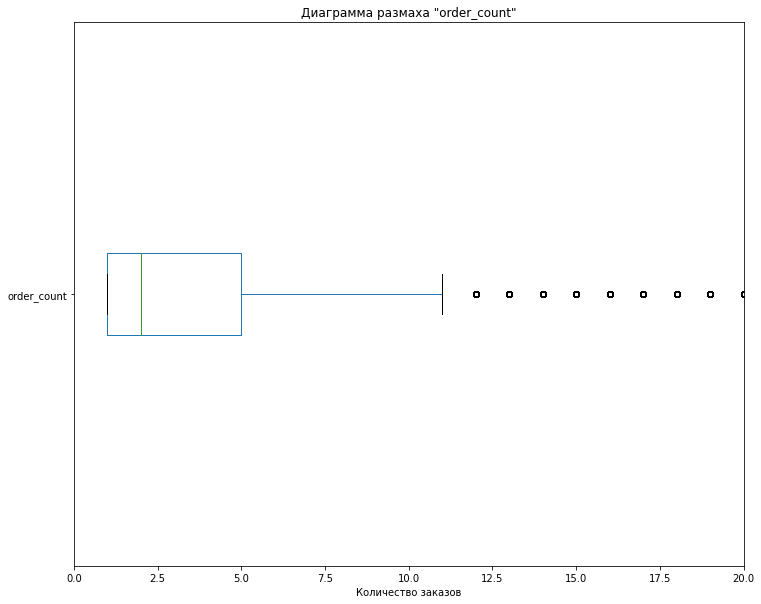

In [193]:
userpr_df['order_count'].plot(kind='box',
                           figsize=(12,10),
                           vert=False,
                           title='Диаграмма размаха "order_count"')
plt.xlim(left=0,right=20)
plt.xlabel('Количество заказов')

In [194]:
order_count87=np.percentile(userpr_df['order_count'],87)

In [195]:
order_count87

11.0

In [196]:
userpr_df['tickets_count_mean'].describe()

count    21848.000000
mean         2.742918
std          0.913389
min          1.000000
25%          2.000000
50%          2.750000
75%          3.076923
max         11.000000
Name: tickets_count_mean, dtype: float64

Text(0.5, 0, 'Количество билетов')

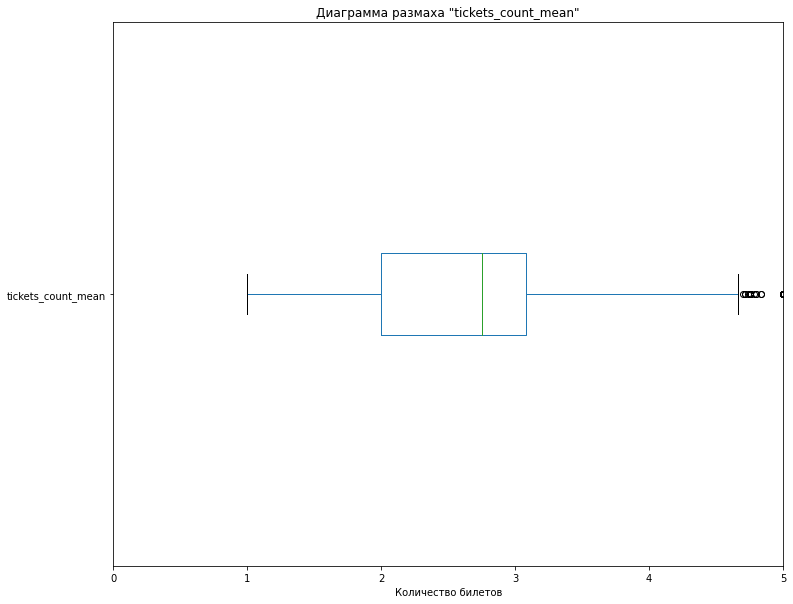

In [197]:
userpr_df['tickets_count_mean'].plot(kind='box',
                           figsize=(12,10),
                           vert=False,
                           title='Диаграмма размаха "tickets_count_mean"')
plt.xlim(left=0,right=5)
plt.xlabel('Количество билетов')

In [198]:
tickets_count_mean96=np.percentile(userpr_df['tickets_count_mean'],96)

In [199]:
tickets_count_mean96

4.333333333333333

In [200]:
userpr_df['days_since_prev_mean'].describe()

count    13510.000000
mean        15.863060
std         22.321573
min          0.000000
25%          1.000000
50%          8.000000
75%         20.428572
max        148.000000
Name: days_since_prev_mean, dtype: float64

Text(0.5, 0, 'Количество дней')

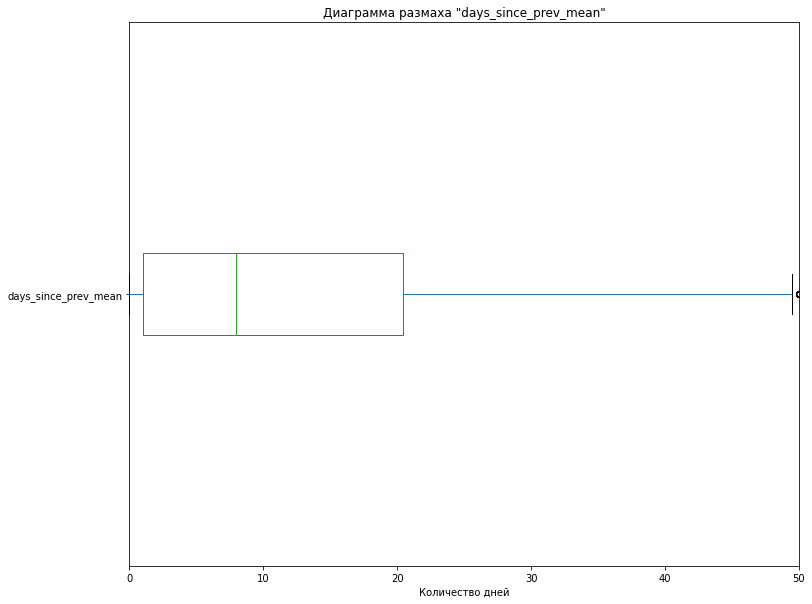

In [201]:
userpr_df['days_since_prev_mean'].plot(kind='box',
                           figsize=(12,10),
                           vert=False,
                           title='Диаграмма размаха "days_since_prev_mean"')
plt.xlim(left=0,right=50)
plt.xlabel('Количество дней')

In [202]:
filt_df=userpr_df[(userpr_df['order_count']<=order_count87)&(userpr_df['tickets_count_mean']<=tickets_count_mean96)]

In [203]:
(userpr_df['user_id'].count())-(filt_df['user_id'].count())

3616

In [204]:
filt_df.describe()

,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
count,18232.000000,18232.000000,18232.000000,10429.000000,18232.000000,18232.000000
mean,2.825965,532.830872,2.633371,18.729578,0.570645,0.193561
std,2.431428,433.274078,0.825403,23.996197,0.494998,0.395099
min,1.000000,-10.770000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,186.047501,2.000000,0.333333,0.000000,0.000000
50%,2.000000,442.497498,2.666667,12.000000,1.000000,0.000000
75%,4.000000,779.989990,3.000000,25.500000,1.000000,0.000000
max,11.000000,2624.814697,4.333333,148.000000,1.000000,1.000000


Общее число пользователей в выборке - 21848, средняя выручка - 532, доля пользователей совершивших 2 и более заказа - 62%, 5 и более заказов - 29%.

В данных о количестве заказов order_count пристутствуют аномальные значения, которые сильно влияют на среднее и стандартное отклонение.
Исходя из диаграммы размаха для order_count решено отфильтровать данные по 87-му процентилю, чтобы исключить аномальные значения.

В данных о среднем количестве билетов также присутствуют аномальные значения, которые отфильтрованы по 96-му процентилю также исходя из диаграммы размаха.

Общий объем отфильтрованных данных составил - 3616 строк.

Отфильтрованный датасет содержит 18232 строк.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [205]:
filt_df.head()

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [206]:
event_type_gr=filt_df.groupby('event_type_first')['user_id'].count().sort_values(ascending=False)

In [207]:
event_type_gr/filt_df['user_id'].count()

event_type_first
концерты    0.446413
другое      0.248135
театр       0.193287
стендап     0.051777
спорт       0.035871
выставки    0.019855
ёлки        0.004662
Name: user_id, dtype: float64

In [208]:
device_type_gr=filt_df.groupby('device_type')['user_id'].count().sort_values(ascending=False)

In [209]:
device_type_gr/filt_df['user_id'].count()

device_type
mobile     0.834631
desktop    0.165369
Name: user_id, dtype: float64

In [210]:
region_gr=filt_df.groupby('region')['user_id'].count().sort_values(ascending=False)

In [211]:
region_gr

region
каменевский регион          5925
североярская область        3101
широковская область         1033
озернинский край             587
малиновоярский округ         463
                            ... 
залесский край                 2
верхозёрский край              1
светолесский край              1
сосноводолинская область       1
яснопольский округ             1
Name: user_id, Length: 81, dtype: int64

In [212]:
region_gr/filt_df['user_id'].count()

region
каменевский регион          0.324978
североярская область        0.170086
широковская область         0.056659
озернинский край            0.032196
малиновоярский округ        0.025395
                              ...   
залесский край              0.000110
верхозёрский край           0.000055
светолесский край           0.000055
сосноводолинская область    0.000055
яснопольский округ          0.000055
Name: user_id, Length: 81, dtype: float64

In [213]:
service_name_gr=filt_df.groupby('service_name_first')['user_id'].count().sort_values(ascending=False)

In [214]:
service_name_gr/filt_df['user_id'].count()

service_name_first
билеты без проблем        0.238482
мой билет                 0.137944
лови билет!               0.130265
билеты в руки             0.116828
облачко                   0.104212
весь в билетах            0.059401
лучшие билеты             0.055342
прачечная                 0.025066
край билетов              0.020294
дом культуры              0.016290
яблоко                    0.014864
тебе билет!               0.014480
городской дом культуры    0.009928
мир касс                  0.009544
за билетом!               0.009434
быстробилет               0.007624
show_ticket               0.007350
выступления.ру            0.004333
восьмёрка                 0.004004
быстрый кассир            0.002249
росбилет                  0.001975
crazy ticket!             0.001865
радио ticket              0.001700
телебилет                 0.001426
реестр                    0.001316
цвет и билет              0.000932
шоу начинается!           0.000932
карандашру                0.000658
к

Почти у половины пользователей первым мероприятием идет «Концерт», первый заказ у 83% пользователей с мобильного телефона, треть пользователей из Каменевского региона, сделавшие заказ из у билетного оператора «билеты без проблем»(24% пользователей)

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [215]:
filt_df.head()

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [216]:
event_share=filt_df.groupby(['event_type_first','is_two'])['user_id'].count()

In [217]:
event_share

event_type_first  is_two
выставки          0          144
                  1          218
другое            0         1997
                  1         2527
концерты          0         3500
                  1         4639
спорт             0          309
                  1          345
стендап           0          402
                  1          542
театр             0         1439
                  1         2085
ёлки              0           37
                  1           48
Name: user_id, dtype: int64

In [218]:
event_plot=(event_share/event_type_gr).unstack(fill_value=0)

In [219]:
event_plot

is_two,0,1
event_type_first,,
выставки,0.397790,0.602210
другое,0.441424,0.558576
концерты,0.430028,0.569972
спорт,0.472477,0.527523
стендап,0.425847,0.574153
театр,0.408343,0.591657
ёлки,0.435294,0.564706


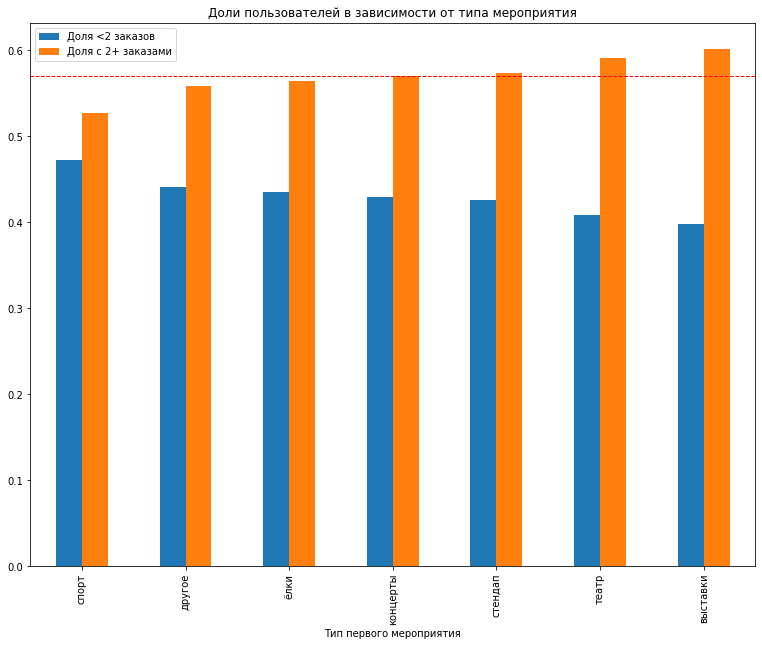

In [220]:
event_plot.sort_values(by=1).plot(kind='bar',
                figsize=(13,10),
                title='Доли пользователей в зависимости от типа мероприятия',
                xlabel='Тип первого мероприятия')
plt.legend(['Доля <2 заказов','Доля с 2+ заказами'])

mean_0=event_plot[1].mean()
plt.axhline(y=mean_0,color='red',linestyle='--', linewidth=1,)


In [221]:
event_type_gr

event_type_first
концерты    8139
другое      4524
театр       3524
стендап      944
спорт        654
выставки     362
ёлки          85
Name: user_id, dtype: int64

In [222]:
device_share=filt_df.groupby(['device_type','is_two'])['user_id'].count()

In [223]:
device_plot=(device_share/device_type_gr).unstack(fill_value=0)

In [224]:
device_plot

is_two,0,1
device_type,,
desktop,0.410282,0.589718
mobile,0.433134,0.566866


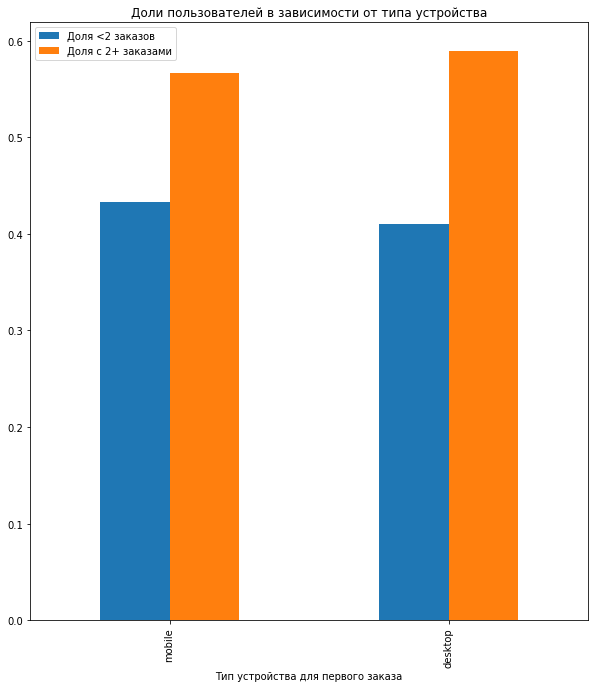

In [225]:
device_plot.sort_values(by=1).plot(kind='bar',
                figsize=(10,11),
                title='Доли пользователей в зависимости от типа устройства',
                xlabel='Тип устройства для первого заказа')
plt.legend(['Доля <2 заказов','Доля с 2+ заказами'])

In [226]:
device_type_gr

device_type
mobile     15217
desktop     3015
Name: user_id, dtype: int64

In [227]:
region_share=filt_df.groupby(['region','is_two'])['user_id'].count()

In [228]:
region_plot=(region_share/region_gr).unstack(fill_value=0)

In [229]:
region_plot_sorted=region_plot.loc[region_gr.index]

In [230]:
region_plot_sorted

is_two,0,1
region,,
каменевский регион,0.419916,0.580084
североярская область,0.403741,0.596259
широковская область,0.385286,0.614714
озернинский край,0.480409,0.519591
малиновоярский округ,0.483801,0.516199
...,...,...
залесский край,0.500000,0.500000
верхозёрский край,0.000000,1.000000
светолесский край,1.000000,0.000000


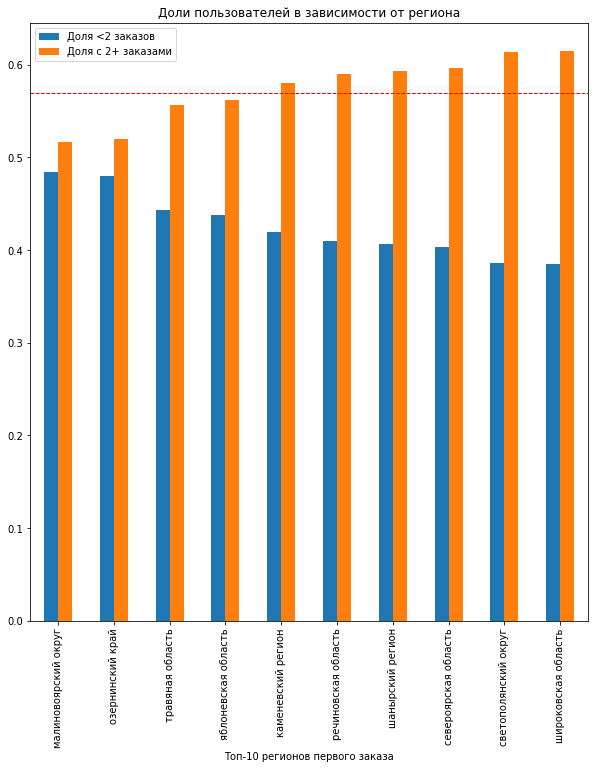

In [231]:
region_plot_sorted.head(10).sort_values(by=1).plot(kind='bar',
                                 figsize=(10,11),
                                 title='Доли пользователей в зависимости от региона',
                                 xlabel='Топ-10 регионов первого заказа')
plt.legend(['Доля <2 заказов','Доля с 2+ заказами'])

mean_r=region_plot_sorted[1].mean()
plt.axhline(y=mean_0,color='red',linestyle='--', linewidth=1,)

In [232]:
region_gr.head(10)

region
каменевский регион      5925
североярская область    3101
широковская область     1033
озернинский край         587
малиновоярский округ     463
травяная область         406
шанырский регион         398
светополянский округ     381
речиновская область      371
яблоневская область      354
Name: user_id, dtype: int64

In [233]:
service_share=filt_df.groupby(['service_name_first','is_two'])['user_id'].count()

In [234]:
service_plot=(service_share/service_name_gr).unstack(fill_value=0)

In [235]:
service_plot_sorted=service_plot.loc[service_name_gr.index]

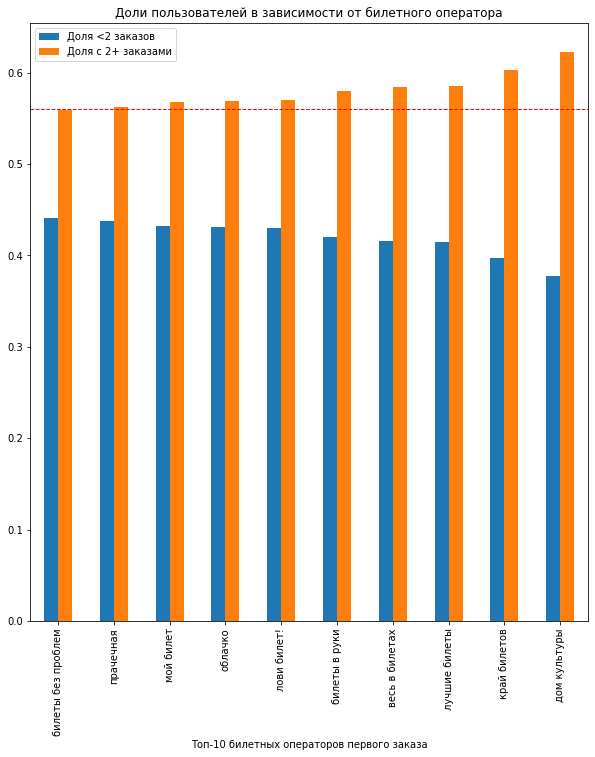

In [236]:
service_plot_sorted.head(10).sort_values(by=1).plot(kind='bar',
                                 figsize=(10,11),
                                 title='Доли пользователей в зависимости от билетного оператора',
                                 xlabel='Топ-10 билетных операторов первого заказа')
plt.legend(['Доля <2 заказов','Доля с 2+ заказами'])

mean_s=service_plot_sorted[1].mean()
plt.axhline(y=mean_s,color='red',linestyle='--', linewidth=1,)

In [237]:
service_name_gr.head(10)

service_name_first
билеты без проблем    4348
мой билет             2515
лови билет!           2375
билеты в руки         2130
облачко               1900
весь в билетах        1083
лучшие билеты         1009
прачечная              457
край билетов           370
дом культуры           297
Name: user_id, dtype: int64


Сегменты 'Концерты', 'другое' и 'театр' чаще всего возвращаются на платформу. 
 
По типу устройства заказы с mobile-устройств чаще возвращаются за 2-м заказом.

По региону наиболее активные области это: 
-Каменевский регион 
-Североярская область 
-Широковская область  


Наиболее активные пользователи у билетных операторов:
-Билеты без проблем 
-Край билетов 
-Мой билет 
-Лови билет!


По типу мероприятия успешные точки входа наблбдаются незначительно у типа «выставки» и «театр»
По региону успешные точки входа тоже незначительны и наблюдается у широковской области и светополянского округа, но там маленькое население (1033 и 381)
По типу билетов успешные точки входа у «Дом культуры» и «край билетов», но у них незначительное количество пользователей

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

Гипотеза 1 

У пользователей, совершивших заказ на концерты % оформивших 2 заказ выше(57%), чем у тех, кто купил билеты на спорт (53%), поэтому первые с большей вероятностью совершат повторный заказ 


Гипотеза 2 

В менее активных регионах доля повторных заказов выше чем в регионах с большим количеством пользователей

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [238]:
filt_df.head()

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [239]:
one_order=filt_df[filt_df['is_two']==0]

In [240]:
two_orders=filt_df[filt_df['is_two']==1]

Text(0.5, 0, 'Средняя выручка')

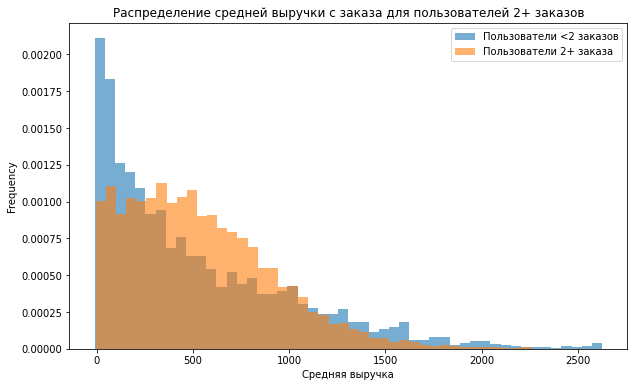

In [241]:
one_order['revenue_rub_mean'].plot(kind='hist',
                                   bins=50, 
                                   figsize=(10,6),
                                   alpha=0.6,
                                   density=True,
                                   title='Распределение средней выручки с заказа для пользователей <2 заказов')
two_orders['revenue_rub_mean'].plot(kind='hist',
                                   bins=50, 
                                   figsize=(10,6),
                                   alpha=0.6,
                                   density=True,
                                   title='Распределение средней выручки с заказа для пользователей 2+ заказов')
plt.legend(['Пользователи <2 заказов','Пользователи 2+ заказа'])
plt.xlabel('Средняя выручка')

Первая группа в основном покупает недорогие билеты, много аномалий и выбросов.

У второй группы график стабильнее, разнообразные мероприятия, билеты подороже и выбросов меньше.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [242]:
four_order=filt_df[(filt_df['order_count']>=2)&(filt_df['order_count']<=4)]

In [243]:
five_orders=filt_df[filt_df['is_five']==1]

Text(0.5, 0, 'Средняя выручка')

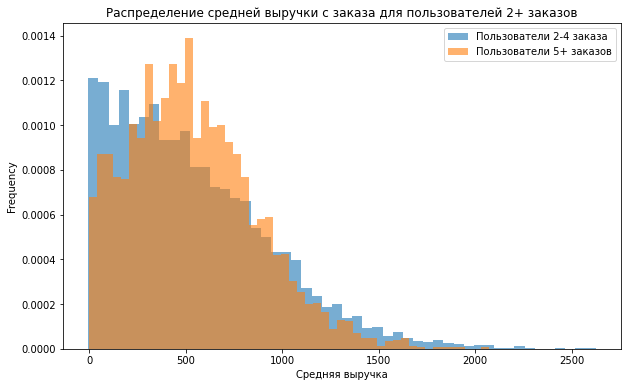

In [244]:
four_order['revenue_rub_mean'].plot(kind='hist',
                                   bins=50, 
                                   figsize=(10,6),
                                   alpha=0.6,
                                   density=True,
                                   title='Распределение средней выручки с заказа для пользователей 2-4 заказа')
five_orders['revenue_rub_mean'].plot(kind='hist',
                                   bins=50, 
                                   figsize=(10,6),
                                   alpha=0.6,
                                   density=True,
                                   title='Распределение средней выручки с заказа для пользователей 2+ заказов')
plt.legend(['Пользователи 2-4 заказа','Пользователи 5+ заказов'])
plt.xlabel('Средняя выручка')

У группы (2-4) средняя выручка от 0 до 700

Значение средней выручки у группы (5+) смещена в большую сторону около от 300 до 1000

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [245]:
filt_df.describe()

,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
count,18232.000000,18232.000000,18232.000000,10429.000000,18232.000000,18232.000000
mean,2.825965,532.830872,2.633371,18.729578,0.570645,0.193561
std,2.431428,433.274078,0.825403,23.996197,0.494998,0.395099
min,1.000000,-10.770000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,186.047501,2.000000,0.333333,0.000000,0.000000
50%,2.000000,442.497498,2.666667,12.000000,1.000000,0.000000
75%,4.000000,779.989990,3.000000,25.500000,1.000000,0.000000
max,11.000000,2624.814697,4.333333,148.000000,1.000000,1.000000


<AxesSubplot:ylabel='Frequency'>

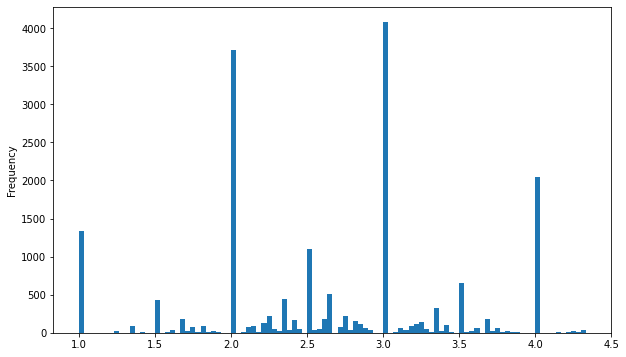

In [246]:
filt_df['tickets_count_mean'].plot(kind='hist',
                                   bins=100,
                                   figsize=(10,6))

In [250]:
ticket_1=filt_df[filt_df['tickets_count_mean']<2]

In [252]:
ticket1_count=ticket_1['user_id'].count()

In [253]:
ticket1_count

2367

In [266]:
ticket1_share=ticket_1.groupby('is_two')['user_id'].count()

In [255]:
ticket1_share/ticket1_count

is_two
0    0.497676
1    0.502324
Name: user_id, dtype: float64

In [256]:
ticket_23=filt_df[(filt_df['tickets_count_mean']>=2)&(filt_df['tickets_count_mean']<3)]

In [257]:
ticket23_count=ticket_23['user_id'].count()

In [258]:
ticket23_count

7585

In [259]:
ticket23_share=ticket_23.groupby('is_two')['user_id'].count()

In [260]:
ticket23_share/ticket23_count

is_two
0    0.330916
1    0.669084
Name: user_id, dtype: float64

In [261]:
ticket_35=filt_df[(filt_df['tickets_count_mean']>=3)&(filt_df['tickets_count_mean']<5)]

In [262]:
ticket35_count=ticket_35['user_id'].count()

In [263]:
ticket35_count

8280

In [264]:
ticket35_share=ticket_35.groupby('is_two')['user_id'].count()

In [265]:
ticket35_share/ticket35_count

is_two
0    0.5
1    0.5
Name: user_id, dtype: float64

Пользователи чаще всего покупают одно и то же количество билетов , поэтому скопления вокруг целых средних чисел и распределение неравномерно 

Сегмент от 2 до 3 билетов показал 67% повторных покупок , что на 17% выше среднего

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [269]:
day_df=filt_df.copy()

In [270]:
day_df['day_of_week']=day_df['first_order'].dt.dayofweek

In [271]:
day_df.head(5)

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five,day_of_week
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0,1
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0,1
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0,5
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0,3
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0,6


In [272]:
day_share=day_df.groupby(['day_of_week','is_two'])['user_id'].count()

In [273]:
day_count=day_df.groupby('day_of_week')['user_id'].count()

In [274]:
day_plot=(day_share/day_count).unstack(fill_value=0)

In [275]:
day_plot

is_two,0,1
day_of_week,,
0,0.417547,0.582453
1,0.431862,0.568138
2,0.415319,0.584681
3,0.440384,0.559616
4,0.435046,0.564954
5,0.418978,0.581022
6,0.447323,0.552677


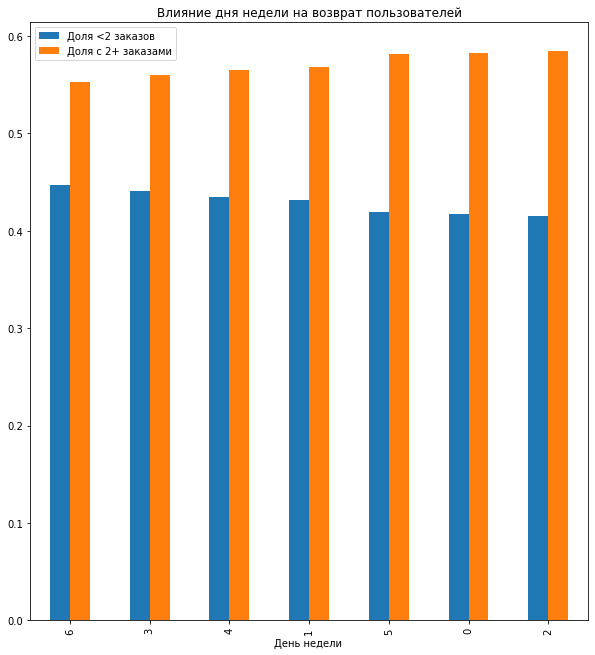

In [276]:
day_plot.sort_values(by=1).plot(kind='bar',
                                 figsize=(10,11),
                                 title='Влияние дня недели на возврат пользователей',
                                 xlabel='День недели ')
plt.legend(['Доля <2 заказов','Доля с 2+ заказами'])

День недели на возврат пользователей почти не влияет: самый низкий %возврата был в воскресенье(55) , самый высокий в среду (58,5)

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [277]:
filt_df.head()

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [278]:
time24_df=filt_df[(filt_df['is_two']==1)&(filt_df['is_five']==0)]

In [279]:
time5plus_df=filt_df[filt_df['is_five']==1]

In [280]:
time24_df['days_since_prev_mean'].mean()

21.46811

In [281]:
time5plus_df['days_since_prev_mean'].mean()

13.20757

У постоянных клиентов с 5+ заказами интервал в полтора раза меньше чем у второй группы. Возможно чем меньше интервал , тем больше вероятность повторного заказа

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [282]:
filt_df.head()

,user_id,first_order,last_order,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,is_two,is_five
0,0002849b70a3ce2,2024-08-20 16:08:03,2024-08-20 16:08:03,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,0,0
1,0005ca5e93f2cf4,2024-07-23 18:36:24,2024-10-06 13:56:02,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.0,1,0
2,000898990054619,2024-07-13 19:40:48,2024-10-23 15:12:00,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.0,1,0
3,00096d1f542ab2b,2024-08-15 16:48:48,2024-08-15 16:48:48,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,0,0
4,000a55a418c128c,2024-09-29 19:39:12,2024-10-15 10:29:04,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.0,1,0


In [283]:
filt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18232 entries, 0 to 21847
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   user_id               18232 non-null  object        
 1   first_order           18232 non-null  datetime64[ns]
 2   last_order            18232 non-null  datetime64[ns]
 3   device_type           18232 non-null  object        
 4   region                18232 non-null  object        
 5   service_name_first    18232 non-null  object        
 6   event_type_first      18232 non-null  object        
 7   order_count           18232 non-null  int64         
 8   revenue_rub_mean      18232 non-null  float32       
 9   tickets_count_mean    18232 non-null  float64       
 10  days_since_prev_mean  10429 non-null  float32       
 11  is_two                18232 non-null  int64         
 12  is_five               18232 non-null  int64         
dtypes: datetime64[ns

In [284]:
!pip install phik

     |████████████████████████████████| 677 kB 1.6 MB/s eta 0:00:01


In [285]:
from phik import phik_matrix
import seaborn as sns

In [286]:
corr_df=day_df[['device_type','region','service_name_first','event_type_first','order_count',
         'revenue_rub_mean','tickets_count_mean','days_since_prev_mean','day_of_week']]

In [287]:
corr_df

,device_type,region,service_name_first,event_type_first,order_count,revenue_rub_mean,tickets_count_mean,days_since_prev_mean,day_of_week
0,mobile,каменевский регион,край билетов,театр,1,1521.939941,4.000000,NaN,1
1,mobile,каменевский регион,мой билет,выставки,2,774.010010,3.000000,75.000,1
2,mobile,североярская область,лови билет!,другое,3,767.213318,2.666667,51.000,5
3,desktop,каменевский регион,край билетов,театр,1,917.830017,4.000000,NaN,3
4,mobile,поленовский край,лучшие билеты,театр,2,61.309998,1.500000,16.000,6
...,...,...,...,...,...,...,...,...,...
21842,mobile,малиновая область,лучшие билеты,другое,4,50.514999,2.250000,26.000,2
21843,mobile,каменевский регион,мой билет,другое,9,688.043335,2.555556,13.375,1
21844,desktop,каменевский регион,билеты без проблем,стендап,2,850.994995,2.500000,74.000,3
21846,desktop,широковская область,билеты без проблем,стендап,1,661.530029,2.000000,NaN,1


In [288]:
corr_matrix=corr_df.phik_matrix()

interval columns not set, guessing: ['order_count', 'revenue_rub_mean', 'tickets_count_mean', 'days_since_prev_mean', 'day_of_week']


In [289]:
corr_matrix['order_count']

device_type             0.029848
region                  0.000000
service_name_first      0.024727
event_type_first        0.022930
order_count             1.000000
revenue_rub_mean        0.238703
tickets_count_mean      0.639623
days_since_prev_mean    0.504421
day_of_week             0.000000
Name: order_count, dtype: float64

<AxesSubplot:>

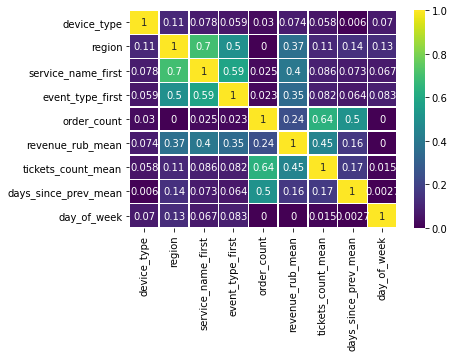

In [290]:
sns.heatmap(corr_matrix,annot=True,linewidths=0.5,cmap='viridis')

Умеренная корреляция order_count с двумя признаками: cреднее кол-во билетов(tickets_count_mean) в заказе и количество дней между заказами(days_since_prev_mean), и слабая с выручкой от заказа(revenue_rub_mean)

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

###### Информация о данных

Данные состоят из двух датасетов: 

df - набор данных о пользователях Яндекс.Афиши, 15 столбцов,290611 строк 
df_currency - Данные о курсе валют за 2024 год, 3 столбца, 357 строк 


Проведена предобработка данных:

В датасете df_currency:

поле “data” приведено к типу datetime для удобства работы и создано поле coeff_cur для возможности перевода в единую валюту 

В датасете df:


- в полях с вещественными и целыми числами понижена размерность
- Категориальные данные приведены к нижнему регистру 
- Создано новое поле revenue_rub, которое отображает выручку в единой валюте - российском рубле 
- добавлено два бинарных признака «is_two»- пользователи сделавшие два заказа и более , «is_five» - сделавшие 5 заказов и более
- 


   Создан профиль пользователя в котором:

      - Данные выручки revenue_rub отфильтрованы по 99-му процентилю 
      - Данные по количеству заказов order_count отфильтрованы по 87-му процентилю
      - Данные по среднему количеству билетов ticket_count_mean в заказе отфильтрованы по 96-му перцентилю

Общий обьем отфильтрованных данных - 3616 строк. 
Отфильтрованный датасет содержит 18232 строки.

###### Основные результаты анализа

Сегменты 'Концерты', 'другое' и 'театр' чаще всего возвращаются на платформу. 
 
Тип мероприятия влияет на вероятность возврата на Яндекс.Афишу. Самый высокий процент возврата у выставок -60%, самый низкий - спорт, 52%

В менее активных регионах доля повторных заказов выше чем в регионах с большим количеством пользователей.

При сравнении групп пользователей по количеству заказов, выяснилось что с увеличением количества заказов пользователи выбирают все более дорогие мероприятия и растет выручка с заказа.

При сравнении групп пользователей по среднему количеству билетов в заказе, выяснилось что сегмент от 2 до 3 билетов показал 67% повторных покупок , что на 17% выше среднего. Возможно семьи,маленькие компании склонны чаще возвращаться на платформу.

День недели на возврат пользователей почти не влияет: самый низкий %возврата был в воскресенье(55) , самый высокий в среду (58,5)

У постоянных клиентов с 5+ заказами интервал между заказами в полтора раза меньше чем у второй группы. Возможно чем меньше интервал , тем больше вероятность повторного заказа.

Количество заказов сильно кореллирует со cредним кол-во билетов в заказе((0,64),умеренно с количеством дней между заказами(0,5) и слабо с выручкой от заказа(0,24)



###### Рекомендации
Обратить внимание на сегменты типа:'концерт','выставка','театр'. У этих категорий самый высокий процент возвратов пользователей.
Обратить внимание на менее активные регионы, там самый высокий % возвратов.
Сделать упор на 'пары','семейных' пользователей и маленькие компании, в этом сегменте на 17% выше возвраты.
Количество заказов сильно коррелирует со средним количеством билетов, возможно стоит пробовать стимулировать пользователей приобретать больше билетов.





### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**